In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import seaborn as sns

import os
import re

In [3]:
def create_dataframe_from_lst_file(lst_filepath: str):
    with open(lst_filepath, newline="\n") as f:
        data = f.readlines()

    with open("data/im2latex_formulas.lst", newline="\n") as f:
        formulas = f.readlines()

    formula_ids = []
    formula_image_ids = []
    formula_texts = []
    formula_render_types = []

    for d in data:
        formula_index, image_name, render_type = d.strip('\n').split(' ')
        formula_index = int(formula_index)

        formula_id = formula_index
        formula_text = formulas[formula_index].strip('\n')
        formula_image_id = image_name
        formula_render_type = render_type

        formula_ids.append(formula_id)
        formula_image_ids.append(formula_image_id)
        formula_texts.append(formula_text)
        formula_render_types.append(formula_render_type)

    df_train = pd.DataFrame.from_dict({ "id": formula_ids, "image_id": formula_image_ids, "text": formula_texts, "render_type": formula_render_types })
    return df_train

In [4]:
df_train = create_dataframe_from_lst_file("data/im2latex_train.lst")
df_val = create_dataframe_from_lst_file("data/im2latex_validate.lst")
df_test = create_dataframe_from_lst_file("data/im2latex_test.lst")

In [5]:
print(f"Train: {len(df_train)} samples")
print(f"Val: {len(df_val)} samples")
print(f"Test: {len(df_test)} samples")

Train: 83884 samples
Val: 9320 samples
Test: 10355 samples


# Exploring Equation Images

In [6]:
def get_cropped_image(image_path: str):
    img = cv2.imread(image_path)
    
    # Convert the image to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Performing OTSU threshold
    ret, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    
    # Specify structure shape and kernel size. 
    # Kernel size increases or decreases the area 
    # of the rectangle to be detected.
    # A smaller value like (10, 10) will detect 
    # each word instead of a sentence.
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 21))
    
    # Applying dilation on the threshold image
    dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1)
    x, y, w, h = cv2.boundingRect(dilation)
    
    # Cropping the text block for giving input to OCR
    im2 = img.copy()
    cropped = im2[y:y + h, x:x + w]
    return cropped

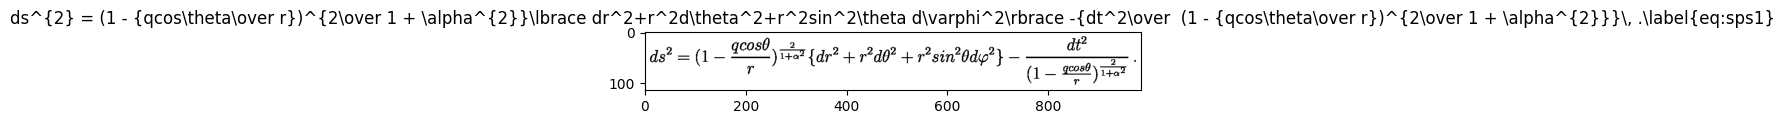

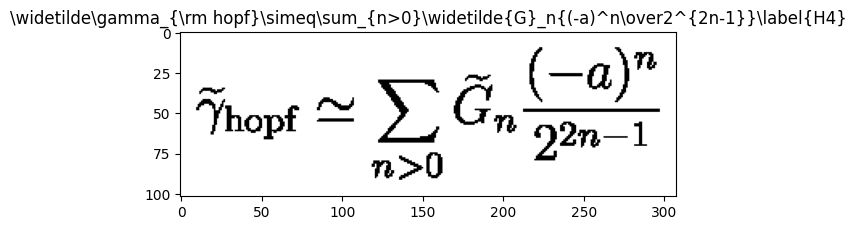

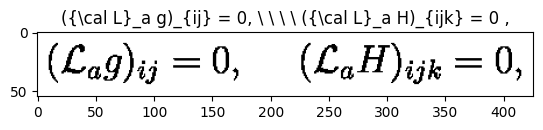

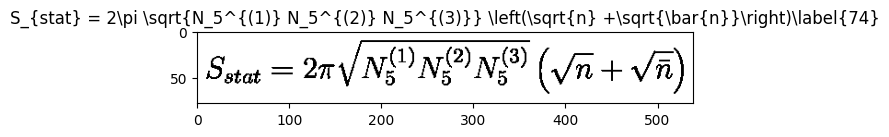

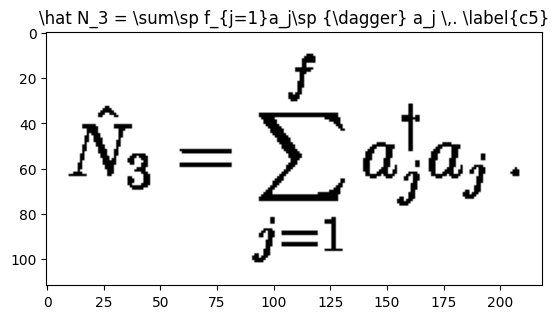

<Figure size 640x480 with 0 Axes>

In [7]:
for index, row in df_train.head(5).iterrows():
    image_id = row['image_id']
    text = row['text']

    cropped_img = get_cropped_image(f'data/formula_images/{image_id}.png')
    plt.imshow(cropped_img)
    plt.title(text)
    plt.figure()

In [8]:
df_train['text'].str.len().describe()

count    83884.000000
mean       118.117591
std         76.957900
min         38.000000
25%         67.000000
50%         98.000000
75%        145.000000
max        997.000000
Name: text, dtype: float64

\begin{array}{|cccccccc|cccccccc|}\hline0 & 2 & 2 & 2 & 2 & 2 & 2 & 2 &  &  &  &  &  &  &  &   \\4 & 4 & 2 & 2 & 2 & 2 & 2 & 2 &  &  &  &  &  &  &  &   \\4 & 4 & 4 & 2 & 2 & 2 & 2 & 2 &  &  &  &  &  &  &  &   \\4 & 4 & 4 & 4 & 2 & 2 & 2 & 2 &  &  &  &  &  &  &  &   \\4 & 4 & 4 & 4 & 4 & 2 & 2 & 2 &  &  &  &  &  &  &  &   \\4 & 4 & 4 & 4 & 4 & 4 & 2 & 2 &  &  &  &  &  &  &  &   \\4 & 4 & 4 & 4 & 4 & 4 & 4 & 2 &  &  &  &  &  &  &  &   \\4 & 4 & 4 & 4 & 4 & 4 & 4 & 4 &  &  &  &  &  &  &  &   \\\hline &  &  &  &  &  &  &  & 4 & 4 & 4 & 4 & 4 & 4 & 4 & 4  \\ &  &  &  &  &  &  &  & 6 & 4 & 4 & 4 & 4 & 4 & 4 & 4  \\ &  &  &  &  &  &  &  & 6 & 6 & 4 & 4 & 4 & 4 & 4 & 4  \\ &  &  &  &  &  &  &  & 6 & 6 & 6 & 4 & 4 & 4 & 4 & 4  \\ &  &  &  &  &  &  &  & 6 & 6 & 6 & 6 & 4 & 4 & 4 & 4  \\ &  &  &  &  &  &  &  & 6 & 6 & 6 & 6 & 6 & 4 & 4 & 4  \\ &  &  &  &  &  &  &  & 6 & 6 & 6 & 6 & 6 & 6 & 4 & 4  \\ &  &  &  &  &  &  &  & 6 & 6 & 6 & 6 & 6 & 6 & 6 & 8  \\\hline\end{array}
\begin{array}{rcl}S\left

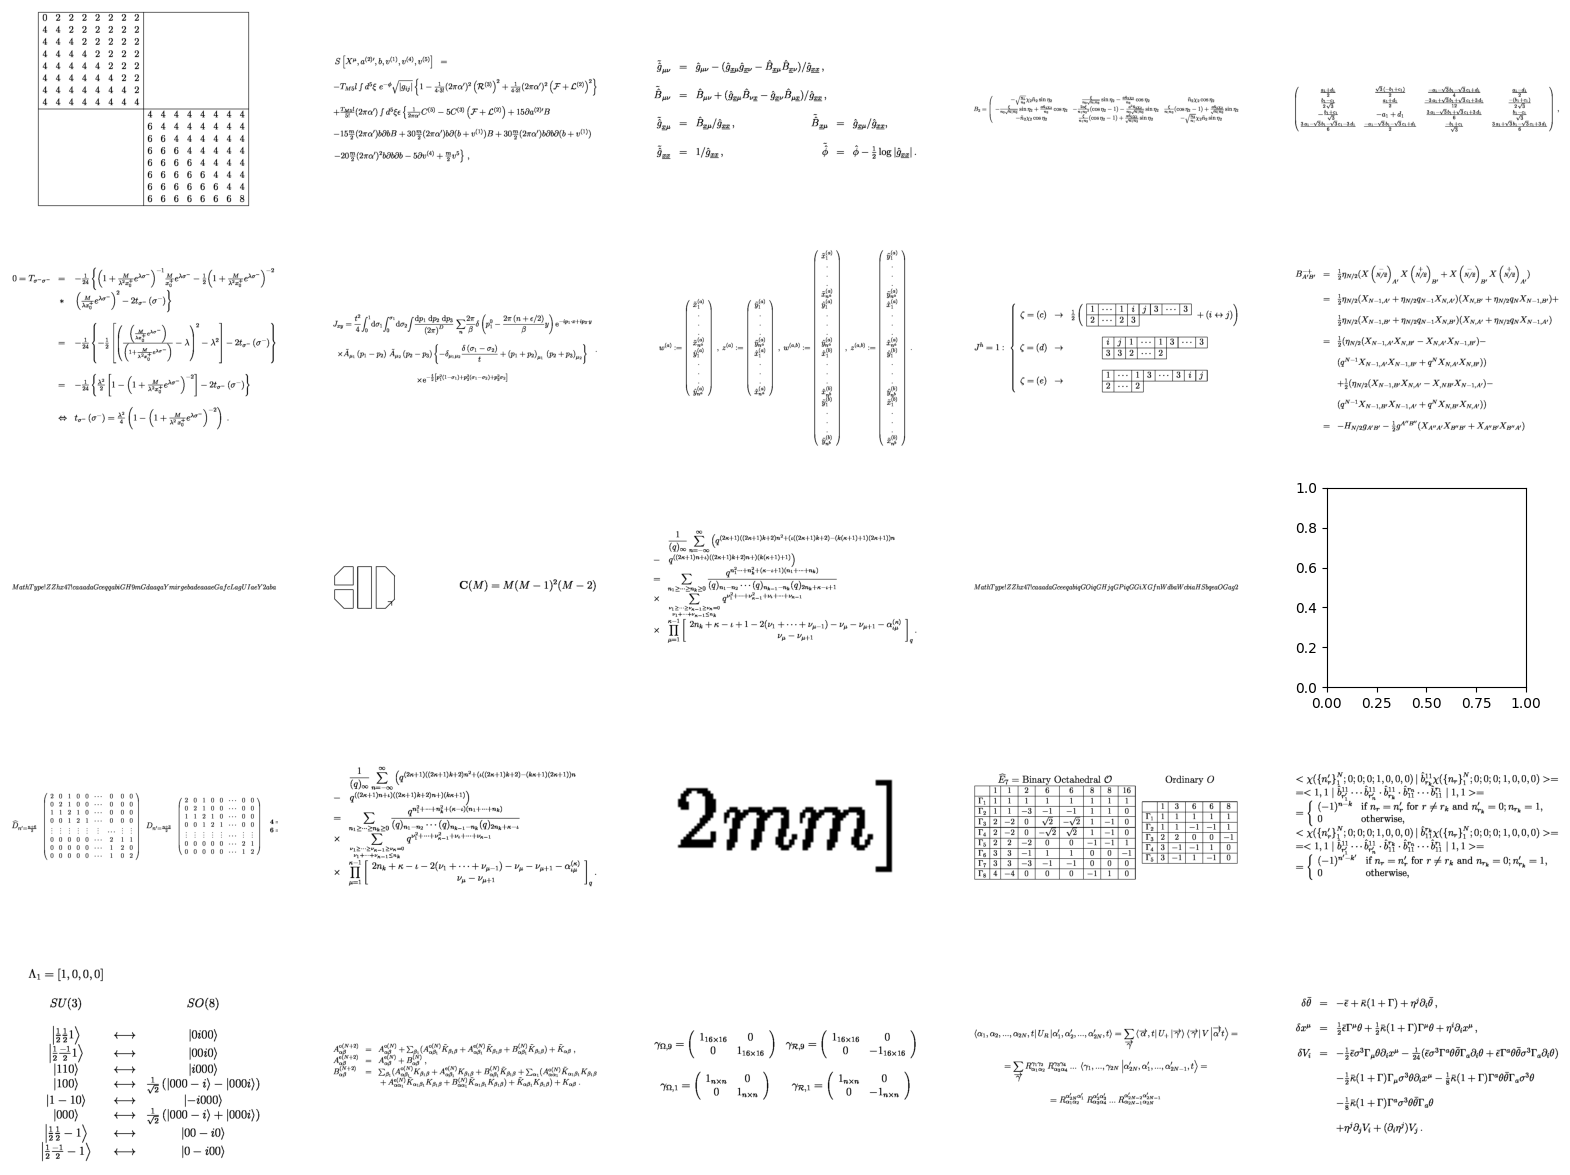

In [9]:
rows, cols = 5, 5
fig, axs = plt.subplots(rows, cols, figsize=(20, 15))
for index, (_, row) in enumerate(df_train[df_train['text'].str.len() > 900].head(25).iterrows()):
    image_id = row['image_id']
    text = row['text']

    print(text)

    cropped_img = get_cropped_image(f'data/formula_images/{image_id}.png')
    x = index // rows
    y = index % cols
    
    # axs[x][y].set_title(text)
    try:
        axs[x][y].imshow(cropped_img)
        axs[x][y].axis('off')
    except Exception as e:
        print("Failed", image_id)

L_{0} = \Phi(w) = \bigtriangleup\Phi(w) ,
x^{c}_{\mu}=x_{\mu}+A_{\mu}.\label{transf}
K_{\mu\nu}~=~\frac{1}{2}\dot{g}_{\mu\nu}.
A_\mu=\bar{A}_\mu (\phi)+a_\mu\ ,\label{37}
\left[ D_f, D \right] = 0\, . \label{13}
\label{newton}\ddot{h} =  - \nabla_h \Phi
e^{\phi^6_c}=-{v_a\over\tilde v_a}\label{critdil}
\Delta {\cal A}=\frac{1}{2}(1+g).  \label{po}
\langle f,f\rangle = \langle g,g\rangle = 0.
G^{(N,M)}(z_1,S_{M+1},\cdots,S_N;z_1,z_2)=0.
E(L)-E_{0}(L)=E_{R}+E_{L}+M\cosh \theta\ ,
x \mapsto \omega(\Xi)(x), \quad \ x \in {\cal O},
g \approx  3-\sqrt 3 - 0.9177 f_{0}^2 \; .
T(z)=L^{ab}:J_a(z) J_b(z): \label{introsimpleT}
n!\prod_{i=1}^kd_i!{1\over (n-m)!}.\label{fac1}
%P\sim \exp\left(-y_0^3/M_p^2\ell\right),%
\alpha^2 \partial_{x^-}^3 g_a(x)=0~; \alpha\neq 0
\hat{\Gamma}_0 \ldots \hat{\Gamma}_{(10)} = 1
B(T)= -\; {b_2(V,T)\over [b_1(V,T)]^2}\;,
\Psi={C}\Psi^{\ast}\,. \label{Majoranacondition}
\sigma_{\pm} = \frac{\tau\pm\sigma}{2}\ .
\label{gfcon}Z ({j _k}) = e ^{i Z_c ({j_k})}
\label{fval

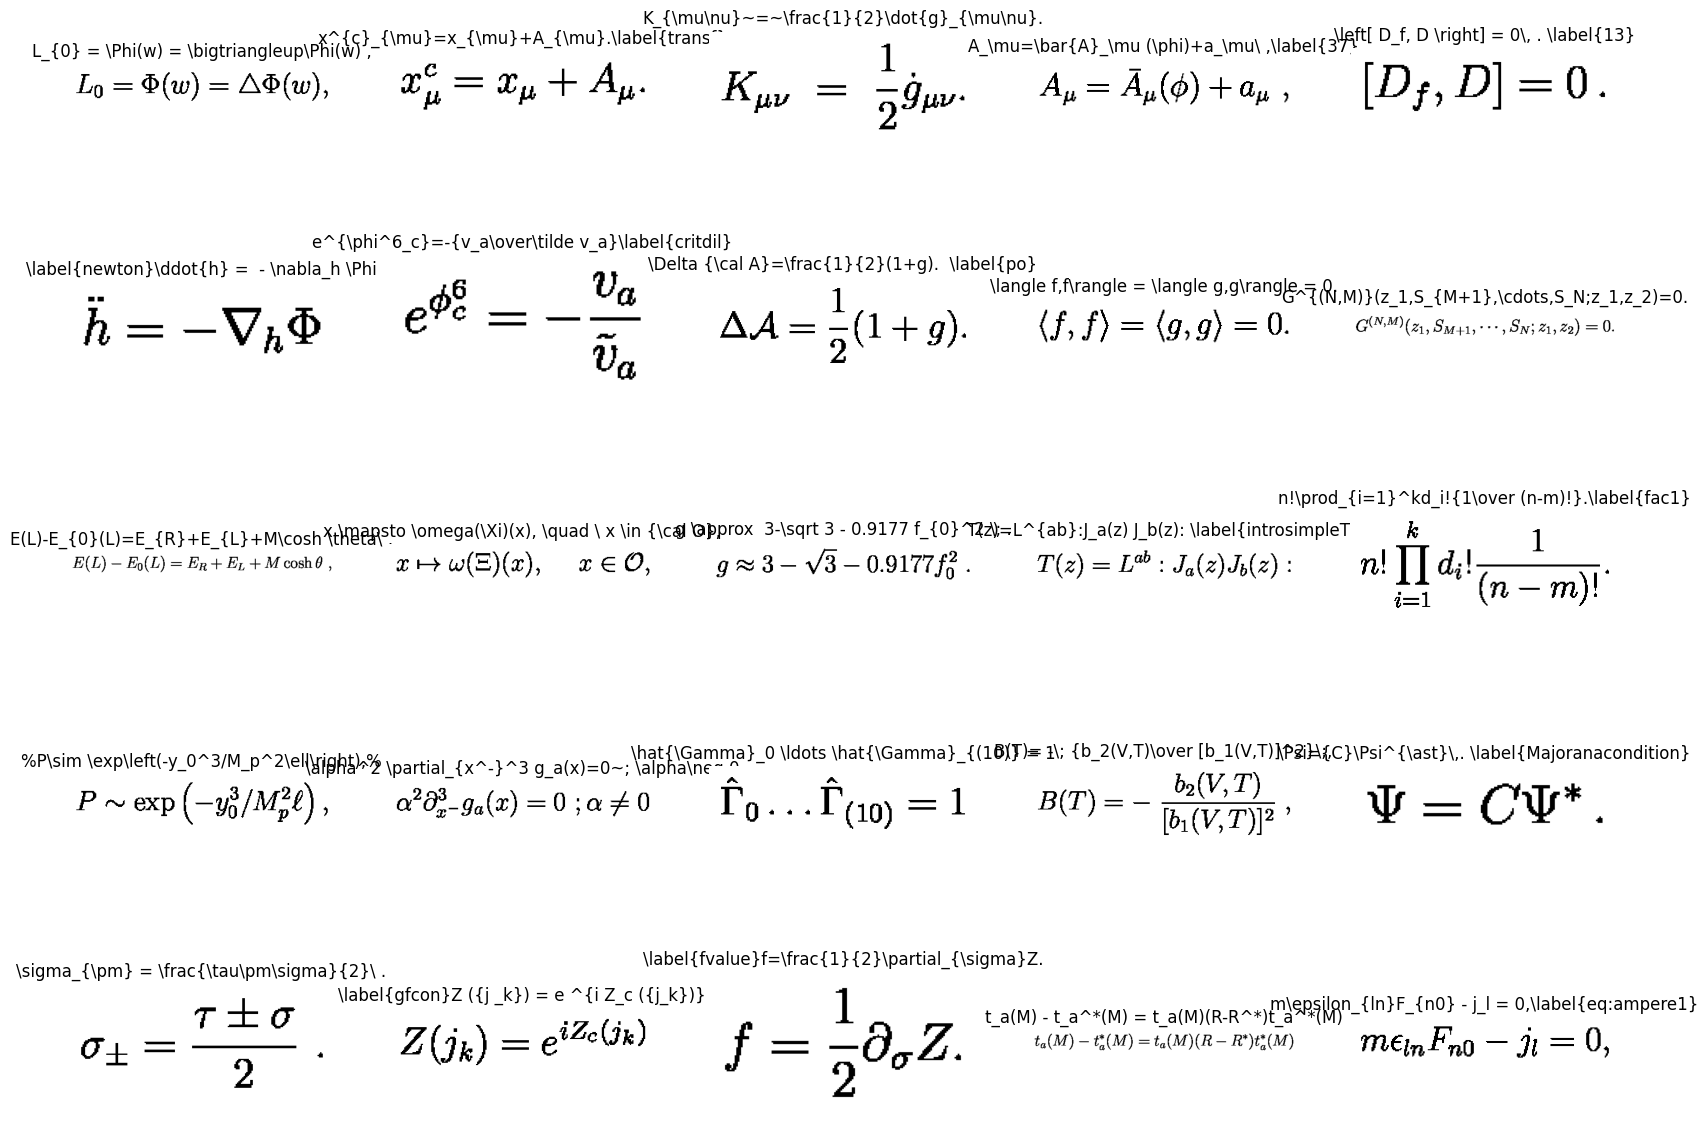

In [10]:
rows, cols = 5, 5
fig, axs = plt.subplots(rows, cols, figsize=(20, 15))
for index, (_, row) in enumerate(df_train[df_train['text'].str.len() < 50].head(25).iterrows()):
    image_id = row['image_id']
    text = row['text']

    cropped_img = get_cropped_image(f'data/formula_images/{image_id}.png')
    x = index // rows
    y = index % cols
    
    print(text)
    axs[x][y].set_title(text)
    axs[x][y].imshow(cropped_img)
    axs[x][y].axis('off')

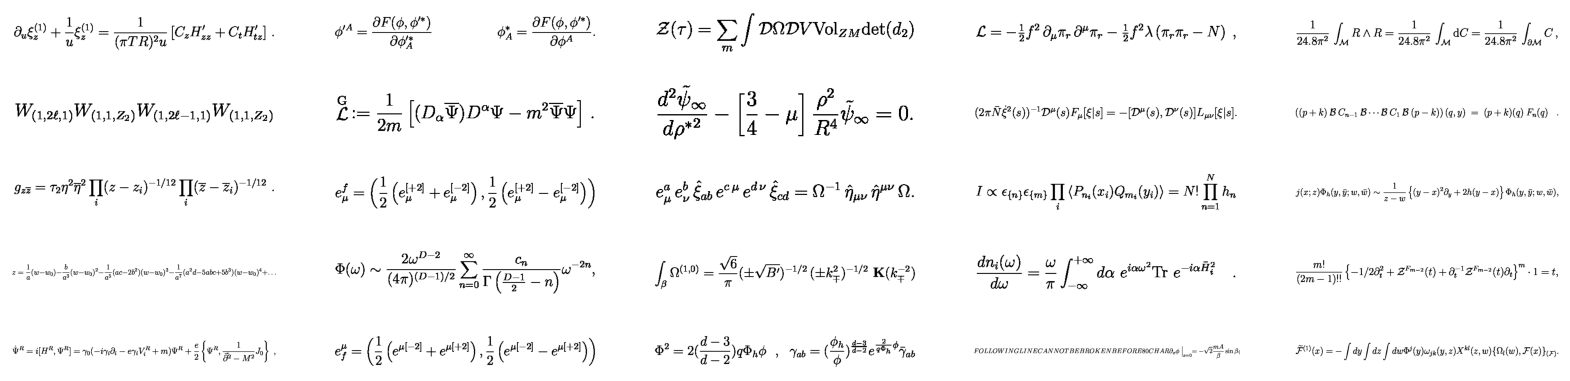

In [11]:
rows, cols = 5, 5
fig, axs = plt.subplots(rows, cols, figsize=(20, 5))
for index, (_, row) in enumerate(df_train[(df_train['text'].str.len() < 150) & (df_train['text'].str.len() > 140)].head(25).iterrows()):
    image_id = row['image_id']
    text = row['text']

    cropped_img = get_cropped_image(f'data/formula_images/{image_id}.png')
    x = index // rows
    y = index % cols
    
    # axs[x][y].set_title(text)
    axs[x][y].imshow(cropped_img)
    axs[x][y].axis('off')

# Checking LaTeX Equations

We want to normalise equations, so we need to parse the equation, and remove anything that is invalid/unsupported

In [114]:
with open("supported_katex_functions/supported_environments.txt", "r") as f:
    supported_environments = set(f.readlines())
    supported_environments = [x.strip('\n') for x in supported_environments]

with open("supported_katex_functions/supported_macros.txt", "r") as f:
    supported_macros = set(f.readlines())
    supported_macros = [x.strip('\n') for x in supported_macros]

In [115]:
from pylatexenc.latexwalker import LatexWalker, LatexCharsNode, LatexGroupNode, LatexMacroNode, LatexSpecialsNode, LatexEnvironmentNode

# keep track of environments and macros present
environments = set()
macros = set()

whitespace_tokens = [" ", "\t"]

def extract_tokens(nodelist):
    if nodelist is None: # if we encounter unsupported nodes, the recursive calls return nodelist=None, so we should return None
        return None
    
    tokens = []
    for node in nodelist:
        if node is None:
            continue
        
        if node.isNodeType(LatexCharsNode): # string of characters without any special latex code
            tokens += [x for x in node.chars if x not in whitespace_tokens]
        elif node.isNodeType(LatexGroupNode): # latex group delimited by either {} or []
            tokens.append(node.delimiters[0])

            subexpression_tokens = extract_tokens(node.nodelist)
            if subexpression_tokens is None:
                return None
            tokens += subexpression_tokens

            tokens.append(node.delimiters[1])
        elif node.isNodeType(LatexMacroNode):
            if node.macroname == "label": # skip labels
                continue

            if node.macroname not in supported_macros:
                print(f"Unsupported macro: {node.macroname}")
                return None

            macros.add(node.macroname)

            tokens.append(rf'\{node.macroname}')

            if node.nodeargd is not None and len(node.nodeargd.argnlist) > 0:
                argnlist_tokens = extract_tokens(node.nodeargd.argnlist)
                if argnlist_tokens is None:
                    return None
                
                tokens += argnlist_tokens
        elif node.isNodeType(LatexSpecialsNode): # special characters
            tokens.append(node.specials_chars)
        elif node.isNodeType(LatexEnvironmentNode):
            if node.environmentname not in supported_environments: # unsupported environments we immediately return None
                print(f"Unsupported environment: {node.environmentname}")
                return None
            
            environments.add(node.environmentname)
            
            tokens.append(r'\begin{' + node.environmentname + '}')

            if node.nodeargd is not None and len(node.nodeargd.argnlist) > 0:
                argnlist_tokens = extract_tokens(node.nodeargd.argnlist)
                if argnlist_tokens is None:
                    return None
                
                tokens += argnlist_tokens

            subexpression_tokens = extract_tokens(node.nodelist)
            if subexpression_tokens is None:
                return None
            tokens += subexpression_tokens

            tokens.append(r'\end{' + node.environmentname + '}')
        else: # here we are left with comments and math nodes, which we will not support
            print("Encountered some special node", node)
            return None

    # replace macros not supported in katex to those that are
    for i in range(len(tokens)):
        if tokens[i] == r'\sp':
            tokens[i] = '^'
        elif tokens[i] == r'\cr':
            tokens[i] = r'\\'

    tokens = [x for x in tokens if x not in whitespace_tokens]

    return tokens

In [116]:
for index, (_, row) in enumerate(df_train.head(1000).iterrows()):
    equation = row['text']
    w = LatexWalker(equation)
    (nodelist, pos, len_) = w.get_latex_nodes()
    
    tokens = extract_tokens(nodelist)

    print("Equation:", equation)
    print("ID:", row['image_id'])
    if tokens is None:
        print("Unsupported expression within")
    else:
        print("Tokenized:", re.sub(' +', ' ', " ".join(tokens)))
        print("Tokens:", tokens)
        
    print()

Equation: ds^{2} = (1 - {qcos\theta\over r})^{2\over 1 + \alpha^{2}}\lbrace dr^2+r^2d\theta^2+r^2sin^2\theta d\varphi^2\rbrace -{dt^2\over  (1 - {qcos\theta\over r})^{2\over 1 + \alpha^{2}}}\, .\label{eq:sps1}
ID: 60ee748793
Tokenized: d s ^ { 2 } = ( 1 - { q c o s \theta \over r } ) ^ { 2 \over 1 + \alpha ^ { 2 } } \lbrace d r ^ 2 + r ^ 2 d \theta ^ 2 + r ^ 2 s i n ^ 2 \theta d \varphi ^ 2 \rbrace - { d t ^ 2 \over ( 1 - { q c o s \theta \over r } ) ^ { 2 \over 1 + \alpha ^ { 2 } } } \, .
Tokens: ['d', 's', '^', '{', '2', '}', '=', '(', '1', '-', '{', 'q', 'c', 'o', 's', '\\theta', '\\over', 'r', '}', ')', '^', '{', '2', '\\over', '1', '+', '\\alpha', '^', '{', '2', '}', '}', '\\lbrace', 'd', 'r', '^', '2', '+', 'r', '^', '2', 'd', '\\theta', '^', '2', '+', 'r', '^', '2', 's', 'i', 'n', '^', '2', '\\theta', 'd', '\\varphi', '^', '2', '\\rbrace', '-', '{', 'd', 't', '^', '2', '\\over', '(', '1', '-', '{', 'q', 'c', 'o', 's', '\\theta', '\\over', 'r', '}', ')', '^', '{', '2', '\\over', 

A random sample to check the original and normalised equation

Original | Normalised
:---: | :---:
$ds^{2} = (1 - {qcos\theta\over r})^{2\over 1 + \alpha^{2}}\lbrace dr^2+r^2d\theta^2+r^2sin^2\theta d\varphi^2\rbrace -{dt^2\over  (1 - {qcos\theta\over r})^{2\over 1 + \alpha^{2}}}\, .$ | $d s ^ { 2 } = ( 1 - { q c o s \theta \over r } ) ^ { 2 \over 1 + \alpha ^ { 2 } } \lbrace d r ^ 2 + r ^ 2 d \theta ^ 2 + r ^ 2 s i n ^ 2 \theta d \varphi ^ 2 \rbrace - { d t ^ 2 \over ( 1 - { q c o s \theta \over r } ) ^ { 2 \over 1 + \alpha ^ { 2 } } } \, .$
$\widetilde\gamma_{\rm hopf}\simeq\sum_{n>0}\widetilde{G}_n{(-a)^n\over2^{2n-1}}$ | $\widetilde \gamma _ { \rm h o p f } \simeq \sum _ { n > 0 } \widetilde { G } _ n { ( - a ) ^ n \over 2 ^ { 2 n - 1 } }$
$V_{ns}({\tilde x})= \left(\frac{{\tilde m}N^2}{16\pi}\right)N g^{2ns-1}{\tilde x}^2 \left\{{\tilde x}^2 -\frac{2{\tilde b}}{3}{\tilde x}+\frac{{\tilde b}^2}{3} -(-1)^{ns}{\tilde c}\right\} \,.$ | $V _ { n s } ( { \tilde x } ) = \left ( \frac { { \tilde m } N ^ 2 } { 1 6 \pi } \right ) N g ^ { 2 n s - 1 } { \tilde x } ^ 2 \left \{ { \tilde x } ^ 2 - \frac { 2 { \tilde b } } { 3 } { \tilde x } + \frac { { \tilde b } ^ 2 } { 3 } - ( - 1 ) ^ { n s } { \tilde c } \right \} \, .$
$\hat N_3 = \sum^ f_{j=1}a_j^ {\dagger} a_j \,.$ | $\hat N _ 3 = \sum ^ f _ { j = 1 } a _ j ^ { \dagger } a _ j \, .$
$+ \int\!\!d^D\!z_1 d^D\!z_2 d^D\!z_3 \left.       \frac{\delta^2 W}{\delta j(x) \delta j(z_1)} \,       \frac{\delta^2 W}{\delta j(x) \delta j(z_2)} \,       \frac{\delta^2 W}{\delta j(x) \delta j(z_3)} \,       \frac{\delta^3 \Gamma}                  {\delta \Phi(z_1) \delta \Phi(z_2) \delta \Phi(z_3)}          \right] ,$ | $+ \int \! \! d ^ D \! z _ 1 d ^ D \! z _ 2 d ^ D \! z _ 3 \left . \frac { \delta ^ 2 W } { \delta j ( x ) \delta j ( z _ 1 ) } \, \frac { \delta ^ 2 W } { \delta j ( x ) \delta j ( z _ 2 ) } \, \frac { \delta ^ 2 W } { \delta j ( x ) \delta j ( z _ 3 ) } \, \frac { \delta ^ 3 \Gamma } { \delta \Phi ( z _ 1 ) \delta \Phi ( z _ 2 ) \delta \Phi ( z _ 3 ) } \right ] ,$

# Preprocessing and Filtering Data

For each row in our dataframe, we normalise the equation text. Then, we remove any equations that could not be normalised

In [117]:
def normalise_equation(equation: str):
    w = LatexWalker(equation)
    (nodelist, pos, len_) = w.get_latex_nodes()
    
    tokens = extract_tokens(nodelist)
    if tokens is not None:
        return re.sub(' +', ' ', " ".join(tokens))
    else:
        return None

df_train['normalised_text'] = df_train.apply(lambda x: normalise_equation(x['text']), axis=1)

$$
\   
$$

In [118]:
print(environments)
print(macros)

{'array', 'pmatrix', 'cases', 'matrix'}
{'gg', 'biggr', 'longmapsto', 'arcsin', 'widehat', 'Longrightarrow', 'enspace', 'smallint', 'alpha', 'inf', 'omega', 'Omega', 'bigtriangledown', 'langle', 'j', 'lfloor', 'relax', 'qquad', 'overbrace', 'overline', 'breve', 'mu', 'bigoplus', 'rightleftharpoons', 'supset', 'Longleftrightarrow', 'nonumber', 'Bigr', 'bigtriangleup', 'hspace', 'll', 'bf', 'llap', 'ss', 'Phi', "'", 'textnormal', 'hskip', 'epsilon', 'lbrack', 'mp', 'Gamma', 'xi', 'check', 'def', 'setminus', 'dim', 'longrightarrow', 'mkern', 'sqcup', 'varphi', 'mathstrut', 'mathopen', 'gamma', 'cosh', 'vartheta', 'thinspace', 'textit', 'bar', 'lg', 'overleftarrow', 'swarrow', 'min', 'ddot', 'rlap', 'hookrightarrow', 'overrightarrow', 'Biggm', 'ne', 'sqrt', 'fbox', 'not', 'rgroup', 'forall', 'Sigma', 'cong', 'doteq', 'rfloor', 'nabla', 'smash', 'mapsto', 'pi', 'phantom', 'underbrace', 'cot', 'rightarrow', 'rightharpoonup', 'space', 'ddots', 'ni', 'oslash', 'arraystretch', 'int', 'upsilon',

In [119]:
df_train = df_train.dropna()
df_train

,id,image_id,text,render_type,normalised_text
0,1,60ee748793,ds^{2} = (1 - {qcos\theta\over r})^{2\over 1 +...,basic,d s ^ { 2 } = ( 1 - { q c o s \theta \over r }...
1,2,66667cee5b,\widetilde\gamma_{\rm hopf}\simeq\sum_{n>0}\wi...,basic,\widetilde \gamma _ { \rm h o p f } \simeq \su...
2,3,1cbb05a562,"({\cal L}_a g)_{ij} = 0, \ \ \ \ ({\cal L}_a H...",basic,"( { \cal L } _ a g ) _ { i j } = 0 , \ \ \ \ (..."
3,4,ed164cc822,S_{stat} = 2\pi \sqrt{N_5^{(1)} N_5^{(2)} N_5^...,basic,S _ { s t a t } = 2 \pi \sqrt { N _ 5 ^ { ( 1 ...
4,5,e265f9dc6b,\hat N_3 = \sum\sp f_{j=1}a_j\sp {\dagger} a_j...,basic,\hat N _ 3 = \sum ^ f _ { j = 1 } a _ j ^ { \d...
...,...,...,...,...,...
83879,103554,1bcd3aca22,"G = dU^1 dV^1 + dU^2 dV^2 + (dY^1)^2 + (dY^2)^2~,",basic,G = d U ^ 1 d V ^ 1 + d U ^ 2 d V ^ 2 + ( d Y ...
83880,103555,4716707d22,"\psi * \chi \equiv V_{(\infty,-1)}^{(0)}(\psi)...",basic,"\psi * \chi \equiv V _ { ( \infty , - 1 ) } ^ ..."
83881,103556,49efc685a3,D^{\prime \prime }=D^{\prime }D+\xi ^{\prime }...,basic,D ^ { \prime \prime } = D ^ { \prime } D + \xi...
83882,103557,3bb015355b,\Psi[A_i^a]\rightarrow\Psi[(A^{U})_i^{a}],basic,\Psi [ A _ i ^ a ] \rightarrow \Psi [ ( A ^ { ...


In [120]:
df_test['normalised_text'] = df_test.apply(lambda x: normalise_equation(x['text']), axis=1)
df_test = df_test.dropna()

df_val['normalised_text'] = df_val.apply(lambda x: normalise_equation(x['text']), axis=1)
df_val = df_val.dropna()

In [121]:
# checking sizes of all 3

print(f"Number of train samples: {len(df_train)}")
print(f"Number of test samples: {len(df_test)}")
print(f"Number of val samples: {len(df_val)}")

Number of train samples: 76784
Number of test samples: 9511
Number of val samples: 8543


In [122]:
# save everything

df_train.to_csv("data/train.csv", index=False)
df_val.to_csv("data/test.csv", index=False)
df_test.to_csv("data/val.csv", index=False)

# Checking Distributions of Normalised Data

[Text(0.5, 1.0, 'Distribution of equation lengths (val)')]

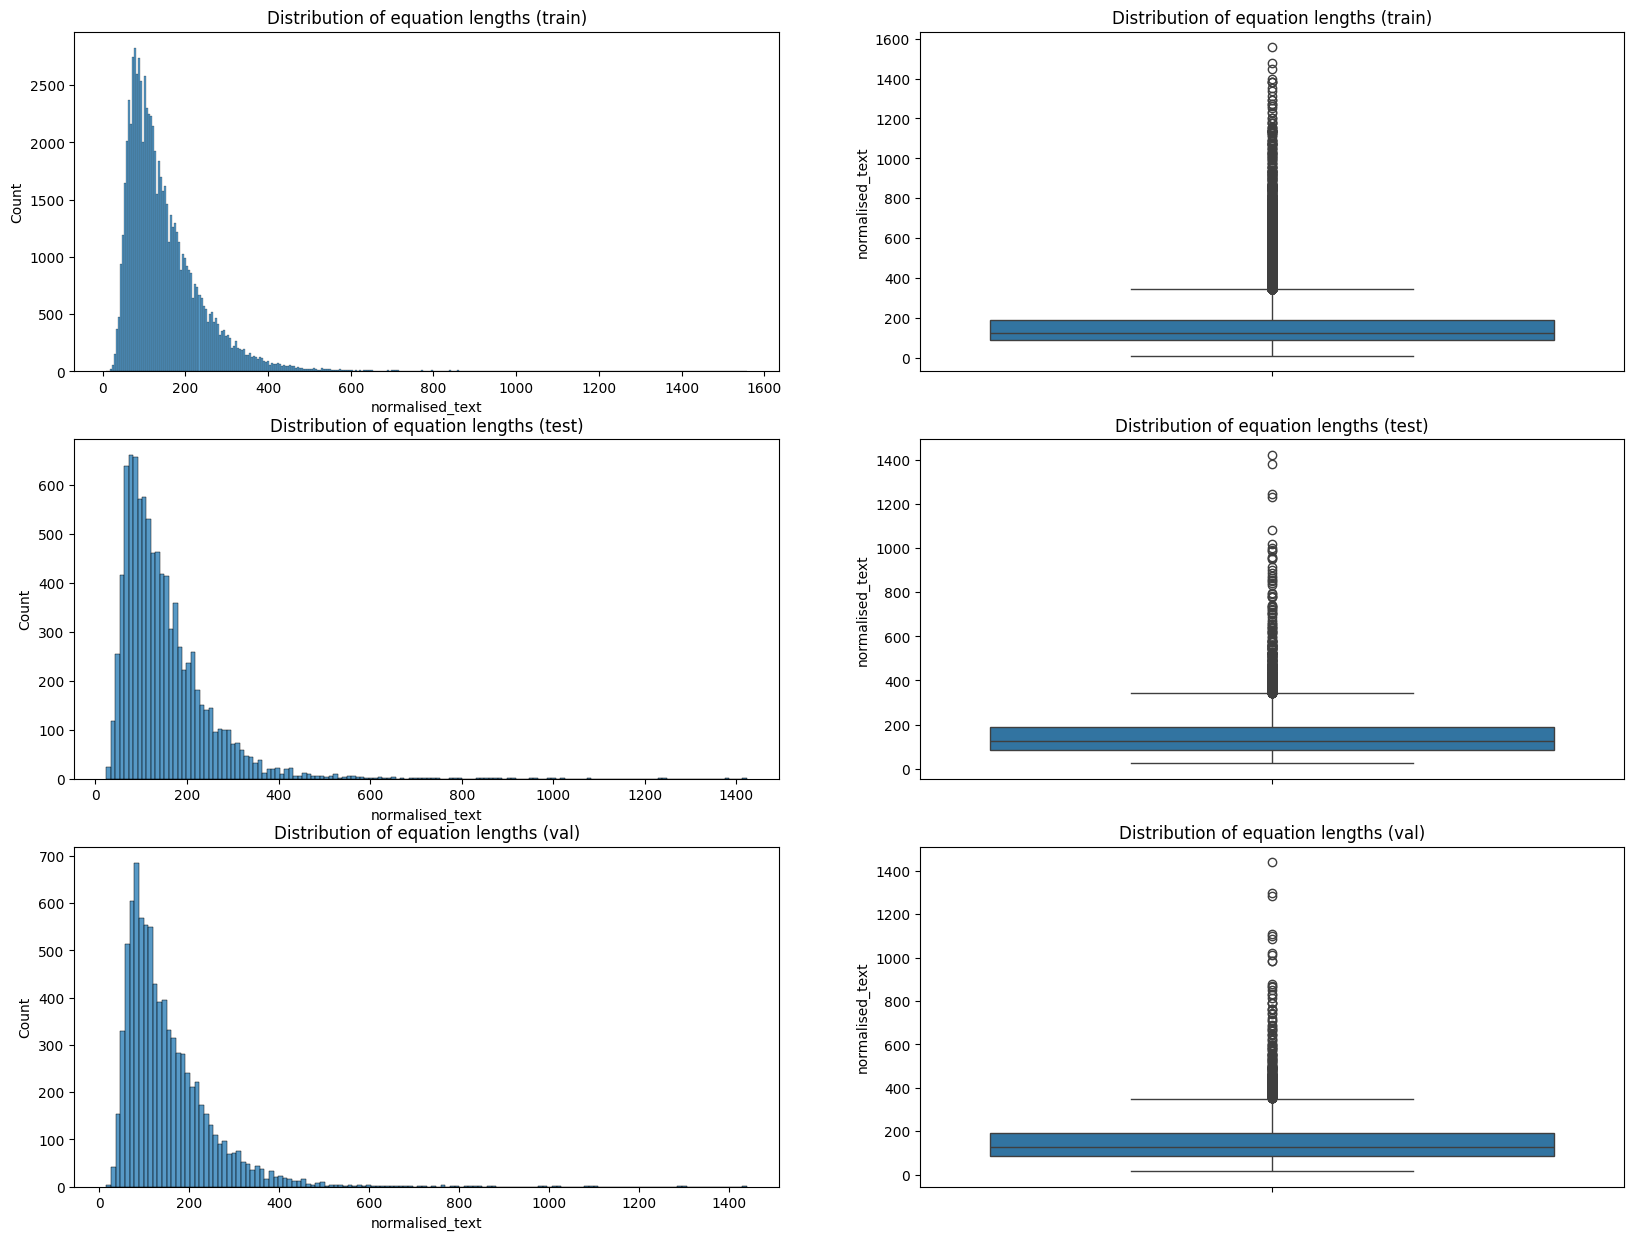

In [123]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))

sns.histplot(df_train['normalised_text'].str.len(), ax=axs[0][0]).set(title="Distribution of equation lengths (train)")
sns.boxplot(df_train['normalised_text'].str.len(), ax=axs[0][1]).set(title="Distribution of equation lengths (train)")

sns.histplot(df_test['normalised_text'].str.len(), ax=axs[1][0]).set(title="Distribution of equation lengths (test)")
sns.boxplot(df_test['normalised_text'].str.len(), ax=axs[1][1]).set(title="Distribution of equation lengths (test)")

sns.histplot(df_val['normalised_text'].str.len(), ax=axs[2][0]).set(title="Distribution of equation lengths (val)")
sns.boxplot(df_val['normalised_text'].str.len(), ax=axs[2][1]).set(title="Distribution of equation lengths (val)")

\begin{array} { l l l } d _ v & = & [ 2 \sum _ { i = 1 } ^ { k - 1 } i ] + [ 2 \sum _ { i = 1 } ^ { m - 1 } i ] + ( 2 H - 2 k + 2 ) k \\ & + & 2 \sum _ { i = 1 } ^ { m - k - 1 } ( k + i ) + m ( N - 2 m + k + 3 ) + ( m + 1 ) ( N - 2 m + k ) \\ & = & [ k ^ 2 - k ] + [ m ^ 2 - m ] + [ 2 k H - 2 k ^ 2 + 2 k ] + [ m ^ 2 - k ^ 2 - k - m ] \\ & + & [ ( 2 m + 1 ) N - 4 m ^ 2 + m + k + 2 k m ] \\ & = & 2 k H + ( 2 m + 1 ) N + 2 k m - 2 k ^ 2 - 2 m ^ 2 - m + k \\ d _ H & = & \sum _ { i = 1 } ^ { k - 1 } [ \frac { 2 i 2 i } { 2 } + \frac { 2 i ( 2 i + 2 ) } { 2 } - i ( 2 i - 1 ) - i ( 2 i + 1 ) ] \\ & + & \sum _ { i = 1 } ^ { m - 1 } [ \frac { ( 2 i + 1 ) 2 i } { 2 } + \frac { 2 i ( 2 i + 3 ) } { 2 } - 2 i ( 2 i + 1 ) ] \\ & + & \frac { ( 2 k ) ^ 2 } { 2 } + \frac { 2 k ( 2 k + 1 ) } { 2 } ( 2 H - 2 k ) - k ( 2 k - 1 ) - ( 2 H - 2 k + 1 ) k ( 2 k + 1 ) \\ & + & \sum _ { i = 1 } ^ { m - k - 1 } [ \frac { ( 2 k + 2 i + 1 ) 2 ( k + i ) } { 2 } + \frac { 2 ( k + i ) ( 2 k + 2 i + 3 ) } { 2 } - 2 ( k 

<Figure size 640x480 with 0 Axes>

) missing from current font.ng\things-to-markdown\venv\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 13 (
  func(*args, **kwargs)
) missing from current font.ng\things-to-markdown\venv\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


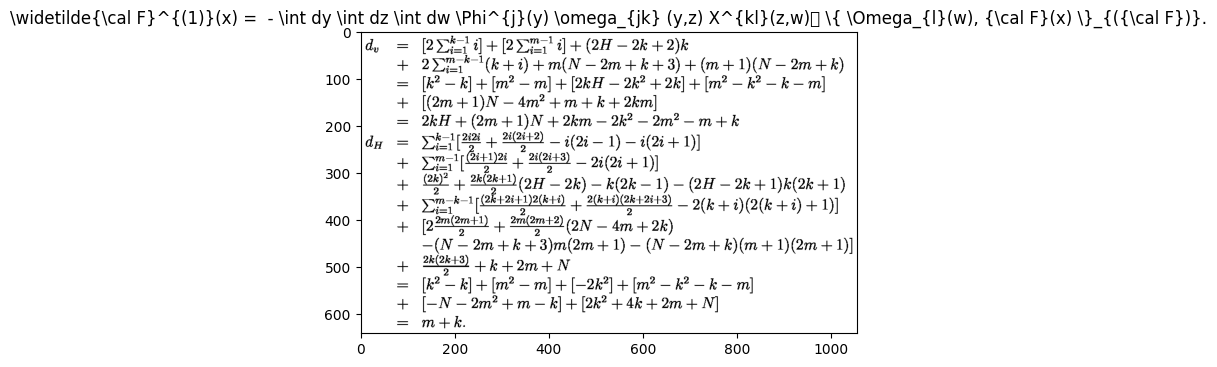

<Figure size 640x480 with 0 Axes>

In [124]:
# checking super long equations

super_long_equations_df = df_train[df_train['normalised_text'].str.len() > 1400]
equation = super_long_equations_df['normalised_text'].values[2]
image_id = super_long_equations_df['image_id'].values[2]

print(equation)

cropped_img = get_cropped_image(f'data/formula_images/{image_id}.png')
plt.imshow(cropped_img)
plt.title(text)
plt.figure()

$$
\begin{array} { l l l } d _ v & = & [ 2 \sum _ { i = 1 } ^ { k - 1 } i ] + [ 2 \sum _ { i = 1 } ^ { m - 1 } i ] + ( 2 H - 2 k + 2 ) k \\ & + & 2 \sum _ { i = 1 } ^ { m - k - 1 } ( k + i ) + m ( N - 2 m + k + 3 ) + ( m + 1 ) ( N - 2 m + k ) \\ & = & [ k ^ 2 - k ] + [ m ^ 2 - m ] + [ 2 k H - 2 k ^ 2 + 2 k ] + [ m ^ 2 - k ^ 2 - k - m ] \\ & + & [ ( 2 m + 1 ) N - 4 m ^ 2 + m + k + 2 k m ] \\ & = & 2 k H + ( 2 m + 1 ) N + 2 k m - 2 k ^ 2 - 2 m ^ 2 - m + k \\ d _ H & = & \sum _ { i = 1 } ^ { k - 1 } [ \frac { 2 i 2 i } { 2 } + \frac { 2 i ( 2 i + 2 ) } { 2 } - i ( 2 i - 1 ) - i ( 2 i + 1 ) ] \\ & + & \sum _ { i = 1 } ^ { m - 1 } [ \frac { ( 2 i + 1 ) 2 i } { 2 } + \frac { 2 i ( 2 i + 3 ) } { 2 } - 2 i ( 2 i + 1 ) ] \\ & + & \frac { ( 2 k ) ^ 2 } { 2 } + \frac { 2 k ( 2 k + 1 ) } { 2 } ( 2 H - 2 k ) - k ( 2 k - 1 ) - ( 2 H - 2 k + 1 ) k ( 2 k + 1 ) \\ & + & \sum _ { i = 1 } ^ { m - k - 1 } [ \frac { ( 2 k + 2 i + 1 ) 2 ( k + i ) } { 2 } + \frac { 2 ( k + i ) ( 2 k + 2 i + 3 ) } { 2 } - 2 ( k + i ) ( 2 ( k + i ) + 1 ) ] \\ & + & [ 2 \frac { 2 m ( 2 m + 1 ) } { 2 } + \frac { 2 m ( 2 m + 2 ) } { 2 } ( 2 N - 4 m + 2 k ) \\ & & - ( N - 2 m + k + 3 ) m ( 2 m + 1 ) - ( N - 2 m + k ) ( m + 1 ) ( 2 m + 1 ) ] \\ & + & \frac { 2 k ( 2 k + 3 ) } { 2 } + k + 2 m + N \\ & = & [ k ^ 2 - k ] + [ m ^ 2 - m ] + [ - 2 k ^ 2 ] + [ m ^ 2 - k ^ 2 - k - m ] \\ & + & [ - N - 2 m ^ 2 + m - k ] + [ 2 k ^ 2 + 4 k + 2 m + N ] \\ & = & m + k . \\ \end{array}
$$
